# Grover FoM Conditional Run Demo
## COSAS IMPORTANTOISIMAS A REVISAR:
    PRIMERO, CUANDO SE PRODUCE EL ON PASS NO FUNCIONA YA QUE ME DICE QUE:
        SamplerV2.run() got an unexpected keyword argument 'lambda_factor'
    ESTO SE PUDE REPLICAR BAJANDO EL TRESHOLD DEL GROVER DE 1.0 A 0.2 POR EJEMPLO. HAY ALGO QUE SE ESTA FILTRANDO. ES RARO YA QUE SOLO PASA CON EL FAKE,MANILLAV2

In [1]:
import os
import logging
from qiskit import QuantumCircuit
# Importar las clases de la biblioteca Qonscious
from qonscious.actions import QonsciousCircuit, QonsciousCallable
from qonscious.adapters import AerSamplerAdapter, IBMSamplerAdapter
from qonscious.checks import MeritComplianceCheck
from qonscious import run_conditionally
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qonscious.adapters import IBMSamplerAdapter

# Importar la clase FoM Grade para Grover
from qonscious.foms import GroverFigureOfMerit


In [2]:
def build_grover_oracle_check_circuit(num_qubits=2) -> QuantumCircuit:
    """Circuito de prueba simple, e.g., preparación de Bell."""
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h(0)
    qc.cx(0, 1)
    qc.measure_all()
    return qc

In [3]:

N_TARGETS = 3 # Número de estados objetivo en el algoritmo de Grover, solo para cuando solo se usa el FoM sin especificar targets
              # ya que son pisados por los del run_conditionally, caso num_qubits como kwargs.
LAMBDA = 0      # Ponderación estricta para uniformidad.
MU = 0          # Ponderación estricta para penalizar el ruido (fail-safe más sensible).
THRESHOLD = 1  # Umbral mínimo de score para considerar el hardware 'fiable'.

def grade_score_over(threshold: float):
    """Función de utilidad para verificar el score GRADE en 'properties'."""
    # Retorna una función lambda que toma el resultado del FoM (r)
    return lambda r: r["properties"]["score"] > threshold

check_grover_is_ok = MeritComplianceCheck(
    figure_of_merit=GroverFigureOfMerit(num_targets=N_TARGETS, lambd=LAMBDA, mu=MU),
    decision_function=grade_score_over(THRESHOLD),
)
# Este seria el No Op en caso de fallo
fallback = QonsciousCallable(
    lambda adapter, fom_results, **kwargs: None,
)


In [4]:

#El aer tira resultados perfectos, asi que el score deberia ser cercano a 1.0, solo incertidumbre estadistica
backend_adapter = AerSamplerAdapter() 

# Alternativamente, usar un backend IBMQ simulado, que dará resultados más realistas, incertidfumbre de hardware y estadística.
#backend_adapter = IBMSamplerAdapter(FakeManilaV2()) # edit as needed

"""TODO: Agregar mas backends, como un backend real de IBMQ (requiere configuración de cuenta y token)."""


qonscious_result = run_conditionally(
    backend_adapter=backend_adapter, checks=[check_grover_is_ok],
    on_pass=QonsciousCircuit(build_grover_oracle_check_circuit()),
    on_fail=fallback,
    #--- Parámetros del FoM de Grover ---
    lambda_factor=LAMBDA, mu_factor=MU,
    num_qubits=4, targets_int=[1,2,9], shots=2000 # Ajustar según sea necesario
)



foms = qonscious_result["figures_of_merit_results"]
firstfom = foms[0]



# La impresion quedo rarisima, asi que debe hacerse mejor, cambiar FOM para que tenga un metodo de impresion?
props = firstfom["properties"]
n = props["num_qubits"]
print("Propiedades:", props)
targets = set(props.get("target_states", []) or [])  # ← acá están los targets
# counts = del experimento del FoM (NO del on_pass)
exp = firstfom.get("experiment_result") or {}             # puede ser None u objeto
counts = exp["counts"] if isinstance(exp, dict) else getattr(exp, "counts", {})
print("n =", n, "counts keys:", sorted(counts.keys())[:10])




Propiedades: {'num_qubits': 4, 'search_space_size': 16, 'targets_count': 3, 'grover_iterations': 1, 'target_states': ['0001', '0010', '1001'], 'score': 0.9500000000000001, 'P_T': 0.9500000000000001, 'sigma_T': 0.002013840995599097, 'P_N': 0.04999999999999993, 'lambda_factor': 0, 'mu_factor': 0, 'shots': 2000}
n = 4 counts keys: ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001']


# Grafico del algoritmo de Grover en Uso
El grafico indica donde es que se van las probabilidades asociados a los targets(*)

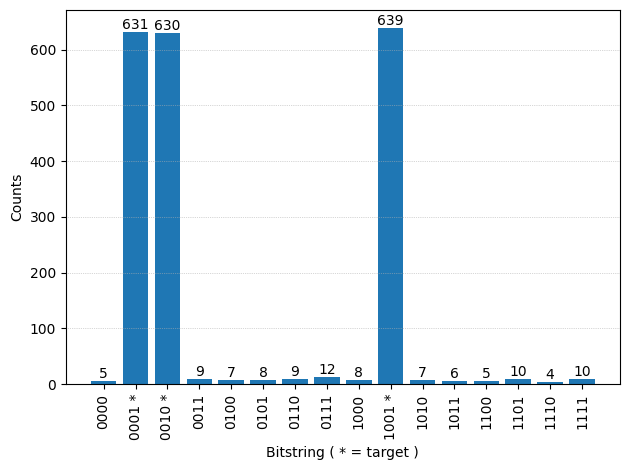

In [5]:
import matplotlib.pyplot as plt

labels = [format(i, f'0{n}b') for i in range(2**n)]
values = [counts.get(b, 0) for b in labels]
tick_labels = [lbl + (" *" if lbl in targets else "") for lbl in labels]

fig, ax = plt.subplots()
bars = ax.bar(range(len(labels)), values)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(tick_labels, rotation=90)
ax.set_ylabel("Counts"); ax.set_xlabel("Bitstring ( * = target )")
ax.grid(True, axis='y', linestyle=':', linewidth=0.5)
for i, bar in enumerate(bars):
    v = values[i]
    if v: ax.text(bar.get_x()+bar.get_width()/2, v, str(v), ha='center', va='bottom')
plt.tight_layout(); plt.show()



# Impresion del circuito
como en el ipynb de Marcos, Luisma y Josema

In [6]:

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt
import math

# --- R óptimo (evita overshoot) ---
def optimal_rounds(N: int, M: int) -> int:
    if M <= 0 or M >= N:
        return 0
    theta = math.asin(math.sqrt(M / N))
    R = int(math.floor((math.pi / (4*theta)) - 0.5))
    return max(0, R)

# --- Oráculo multi-target (endianness corregido) ---
def oracle_mt(targets_bin: list[str], n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n, name="Oracle")
    tgt = n - 1  # qubit objetivo para MCZ
    for t in targets_bin:
        bits_le = list(reversed(t))                      # Qiskit: qubit 0 es LSB
        zeros = [i for i,b in enumerate(bits_le) if b=='0']
        for i in zeros: qc.x(i)                          # pre-conditioning
        qc.h(tgt); qc.mcx(list(range(n-1)), tgt); qc.h(tgt) if n>1 else qc.x(tgt)
        for i in zeros: qc.x(i)                          # post-conditioning
    return qc

# --- Difusor de Grover ---
def diffuser(n: int) -> QuantumCircuit:
    dq = QuantumCircuit(n, name="Diffusion")
    dq.h(range(n)); dq.x(range(n))
    if n>1:
        dq.h(n-1); dq.mcx(list(range(n-1)), n-1); dq.h(n-1)
    else:
        dq.z(0)
    dq.x(range(n)); dq.h(range(n))
    return dq

# --- Construcción del circuito completo ---
def build_grover(n: int, targets_bin: list[str], R: int|None=None, measure=True):
    N = 2**n
    M = len(targets_bin)
    R = optimal_rounds(N, M) if R is None else R

    qc = QuantumCircuit(n, n if measure else 0, name="Grover")
    qc.h(range(n))
    U = oracle_mt(targets_bin, n)
    D = diffuser(n)
    for _ in range(R):
        qc.compose(U, range(n), inplace=True)
        qc.compose(D, range(n), inplace=True)
        qc.barrier()
    if measure:
        qc.measure(range(n), range(n))
    return qc, U, D, R

# ===== Ejemplo: n=4, targets 0000 y 1001 =====
n = 4
targets = ["1111", "1001"]
qc, U, D, R = build_grover(n, targets, R=None, measure=True)

print(f"n={n}, targets={targets}, R={R}\n")

print("=== ORÁCULO ===")
print(U.draw(output="text", idle_wires=False))

print("\n=== DIFUSOR ===")
print(D.draw(output="text", idle_wires=False))

print("\n=== CIRCUITO COMPLETO ===")
print(qc.draw(output="text", idle_wires=False, cregbundle=True))

# (Opcional) ver el circuito transpiled a las compuertas del simulador
sim = AerSimulator()
tqc = transpile(qc, sim, optimization_level=1)
print("\n=== CIRCUITO TRANSPILE ===")
print(tqc.draw(output="text", idle_wires=False, cregbundle=True))



circuit_drawer(qc, output="mpl", fold=-1)   # fold=-1 para no partir líneas
plt.show()


n=4, targets=['1111', '1001'], R=1

=== ORÁCULO ===
                                   
q_0: ───────■──────────────■───────
            │  ┌───┐       │  ┌───┐
q_1: ───────■──┤ X ├───────■──┤ X ├
            │  ├───┤       │  ├───┤
q_2: ───────■──┤ X ├───────■──┤ X ├
     ┌───┐┌─┴─┐├───┤┌───┐┌─┴─┐├───┤
q_3: ┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘└───┘

=== DIFUSOR ===
     ┌───┐┌───┐          ┌───┐┌───┐     
q_0: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤       │  ├───┤├───┤     
q_1: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤       │  ├───┤├───┤     
q_2: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
q_3: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘

=== CIRCUITO COMPLETO ===
     ┌───┐                         ┌───┐┌───┐               ┌───┐┌───┐      ░ »
q_0: ┤ H ├───────■──────────────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├──────░─»
     ├───┤       │  ┌───┐       │  ├───┤├───┤┌───┐ 